In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
data_root = os.path.join('.', 'notMNIST_data') # Change me to store data elsewhere
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

save_dir = os.path.join('notmnist_current_model', 'save')

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    # Import the previously export meta graph.
    # saver = tf.train.import_meta_graph(tf.train.latest_checkpoint(os.getcwd())+".meta")
    # saver.restore(sess, tf.train.latest_checkpoint(os.getcwd()))
    saver = tf.train.import_meta_graph(save_dir + '/model.meta')
    saver.restore(sess, save_dir + '/model')
    print('Model restored.')
    graph = tf.get_default_graph()
    ops = graph.get_operations()
    print(len(ops))
    # print(graph.get_operations())
    # for op in ops:
    #     print(op.name)
    logits = graph.get_tensor_by_name('hidden3/Wx_plus_b/add:0')
    correct_prediction = graph.get_tensor_by_name('accuracy/correct_prediction/Equal:0')
    accuracy = graph.get_tensor_by_name('accuracy/accuracy/Mean:0')
    
    conv1_weights = graph.get_tensor_by_name('conv1/weights/Variable:0')
    conv1_biases = graph.get_tensor_by_name('conv1/biases/Variable:0')
    conv2_weights = graph.get_tensor_by_name('conv2/weights/Variable:0')
    conv2_biases = graph.get_tensor_by_name('conv2/biases/Variable:0')
    
    hidden1_weights = graph.get_tensor_by_name('hidden1/weights/Variable:0')
    hidden1_biases = graph.get_tensor_by_name('hidden1/biases/Variable:0')
    hidden2_weights = graph.get_tensor_by_name('hidden2/weights/Variable:0')
    hidden2_biases = graph.get_tensor_by_name('hidden2/biases/Variable:0')
    hidden3_weights = graph.get_tensor_by_name('hidden3/weights/Variable:0')
    hidden3_biases = graph.get_tensor_by_name('hidden3/biases/Variable:0')
    
    conv1_weights_trained, conv1_biases_trained = sess.run([conv1_weights, conv1_biases])
    conv2_weights_trained, conv2_biases_trained = sess.run([conv2_weights, conv2_biases])
    
    hidden1_weights_trained, hidden1_biases_trained = sess.run([hidden1_weights, hidden1_biases])
    hidden2_weights_trained, hidden2_biases_trained = sess.run([hidden2_weights, hidden2_biases])
    hidden3_weights_trained, hidden3_biases_trained = sess.run([hidden3_weights, hidden3_biases])
    
    logits_valid = sess.run(logits, feed_dict={'input/input_data:0': valid_dataset,
                                            'input/input_labels:0': valid_labels, 'dropout/Placeholder:0' : 1.0})
    
    correct_valid, accuracy_valid = sess.run([correct_prediction, accuracy], feed_dict={'input/input_data:0': valid_dataset,
                                            'input/input_labels:0': valid_labels, 'dropout/Placeholder:0' : 1.0})
    print('valid accuracy %g' % accuracy_valid)
    
    # correct_test, accuracy_test = sess.run([correct_prediction, accuracy], feed_dict={'input/input_data:0': test_dataset,
    #                                         'input/input_labels:0': test_labels, 'dropout/Placeholder:0' : 1.0})
    # print('test accuracy %g' % accuracy_test)
    

INFO:tensorflow:Restoring parameters from notmnist_current_model/save/model
Model restored.
892
valid accuracy 0.8947


In [7]:
predictions_valid = np.argmax(logits_valid, axis=1)
true_valid = np.argmax(valid_labels, axis=1)
label_array = np.zeros([num_labels, num_labels])

for i in np.arange(len(true_valid)):
    predict_label = predictions_valid[i]
    true_label = true_valid[i]
    label_array[true_label, predict_label] += 1

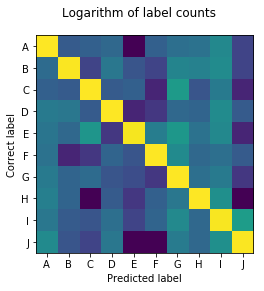

In [8]:
plt.imshow(np.log(label_array))
plt.xticks(np.arange(num_labels), labels)
plt.xlabel('Predicted label')
plt.yticks(np.arange(num_labels), labels)
plt.ylabel('Correct label')
plt.suptitle('Logarithm of label counts')
plt.show()

In [9]:
print(conv1_weights_trained.shape)
print(conv1_biases_trained.shape)
print(conv2_weights_trained.shape)
print(conv2_biases_trained.shape)

print(hidden1_weights_trained.shape)
print(hidden1_biases_trained.shape)
print(hidden2_weights_trained.shape)
print(hidden2_biases_trained.shape)
print(hidden3_weights_trained.shape)
print(hidden3_biases_trained.shape)

(5, 5, 1, 16)
(16,)
(5, 5, 16, 16)
(16,)
(784, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


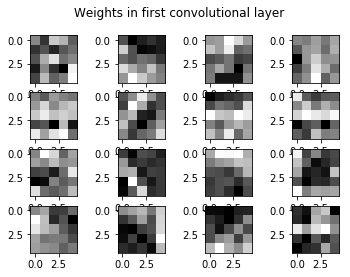

In [10]:
plt.figure(1)
for i in np.arange(conv1_weights_trained.shape[3]):
    plt.subplot(4,4,i+1)
    plt.imshow(conv1_weights_trained[:,:,0,i])
    plt.gray()
plt.suptitle("Weights in first convolutional layer")
plt.show()

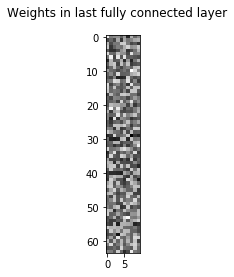

In [11]:
plt.figure(1)
plt.imshow(hidden3_weights_trained)
plt.suptitle("Weights in last fully connected layer")
plt.show()

In [12]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
labels_total_valid = np.zeros([num_labels])
labels_correct_valid = np.zeros([num_labels])
for i in np.arange(num_labels):
    labels_total_valid[i] = np.sum(np.argmax(valid_labels, axis=1) == i)
    labels_correct_valid[i] = np.sum(np.argmax(valid_labels[correct_valid], axis=1) == i)
    print('Label: %s. Accuracy: %f.' % (labels[i], labels_correct_valid[i]/labels_total_valid[i]))

Label: A. Accuracy: 0.913000.
Label: B. Accuracy: 0.887000.
Label: C. Accuracy: 0.903000.
Label: D. Accuracy: 0.904000.
Label: E. Accuracy: 0.844000.
Label: F. Accuracy: 0.912000.
Label: G. Accuracy: 0.919000.
Label: H. Accuracy: 0.907000.
Label: I. Accuracy: 0.868000.
Label: J. Accuracy: 0.890000.


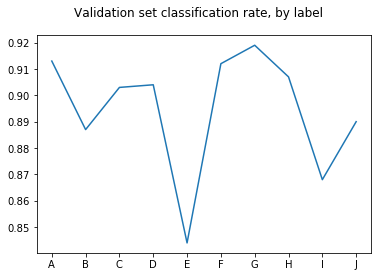

In [13]:
plt.plot(np.arange(num_labels), np.divide(labels_correct_valid,labels_total_valid))
plt.xticks(np.arange(num_labels), labels)
plt.suptitle('Validation set classification rate, by label')
plt.show()